In [428]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

path = Path('titanic')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)
    
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

#### Load data

In [429]:
def load_data(file):
    df = pd.read_csv(path/file)
    df = df.drop(columns=['PassengerId',"Name"])
    return df
train_df = load_data("train.csv")
train_df.shape

(891, 10)

#### Search for NAs

In [430]:
na_counts_per_column = train_df.isna().sum()
print(na_counts_per_column)
train_df.shape


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


(891, 10)

#### Clean & Normalize

In [431]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
train_df = load_data("train.csv")
modes = train_df.mode().iloc[0]
train_df.fillna(modes, inplace=True)

def clean_and_normalize(df):
    df["FareNorm"] = np.log10(df["Fare"] + 1)
    df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])

    df = df.drop(columns=['Cabin'])   # too many missing values
    #df = df.dropna(subset=['Embarked', 'Age'])
    #df['IsMale'] = df["Sex"] == "male"
    #df["AgeNorm"] = df["Age"] / df["Age"].max()
    #df["Emb_S"] = df["Embarked"] == "S"
    #df["Emb_C"] = df["Embarked"] == "C"
    #df["Pclass"] = df["Pclass"] / df["Pclass"].max()
    #df = df.drop(columns=['Sex', "Age", "Fare", "Embarked", "Ticket"])   # drop original columns
    return df

train_df = clean_and_normalize(train_df)

#added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
train_df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


In [433]:
train_df

,Survived,Age,SibSp,Parch,Ticket,Fare,FareNorm,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,A/5 21171,7.2500,0.916454,False,True,False,False,True,False,False,True
1,1,38.0,1,0,PC 17599,71.2833,1.859038,True,False,True,False,False,True,False,False
2,1,26.0,0,0,STON/O2. 3101282,7.9250,0.950608,True,False,False,False,True,False,False,True
3,1,35.0,1,0,113803,53.1000,1.733197,True,False,True,False,False,False,False,True
4,0,35.0,0,0,373450,8.0500,0.956649,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,211536,13.0000,1.146128,False,True,False,True,False,False,False,True
887,1,19.0,0,0,112053,30.0000,1.491362,True,False,True,False,False,False,False,True
888,0,24.0,1,2,W./C. 6607,23.4500,1.388279,True,False,False,False,True,False,False,True
889,1,26.0,0,0,111369,30.0000,1.491362,False,True,True,False,False,True,False,False


In [434]:

train_results = train_df["Survived"]
#train_df = train_df.drop(columns=['Survived'])   

indep_cols = ['Age', 'SibSp', 'Parch', 'FareNorm'] + added_cols
train_df = train_df[indep_cols].astype(float)
train_df.head()


,Age,SibSp,Parch,FareNorm,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1.0,0.0,0.916454,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,0.0,1.859038,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.0,0.0,0.0,0.950608,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.0,1.0,0.0,1.733197,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.0,0.0,0.0,0.956649,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [435]:
train_df.describe()

,Age,SibSp,Parch,FareNorm,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,28.566970,0.523008,0.381594,1.286487,0.647587,0.352413,0.242424,0.206510,0.551066,0.188552,0.086420,0.725028
std,13.199572,1.102743,0.806057,0.420852,0.477990,0.477990,0.428790,0.405028,0.497665,0.391372,0.281141,0.446751
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,0.949897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,0.000000,0.000000,1.189047,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,35.000000,1.000000,0.000000,1.505150,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,80.000000,8.000000,6.000000,2.710396,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Convert to tensor

In [436]:
train_ts = tensor(train_df.values).float()
result_ts = tensor(train_results.values).float()
# add a column with ones
#ones_column = torch.ones(train_ts.shape[0], 1)
#train_ts = torch.cat((train_ts, ones_column), dim=1)

train_ts.shape
train_ts

tensor([[22.0000,  1.0000,  0.0000,  0.9165,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  1.8590,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  0.9506,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  1.7332,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  0.9566,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  0.9758,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  1.7231,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  0.9058,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  1.4789

In [437]:
print(train_results.name, train_df.columns)

Survived Index(['Age', 'SibSp', 'Parch', 'FareNorm', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')


In [438]:
torch.manual_seed(442)

params = torch.rand(train_ts.shape[1])-0.5
#params = params.requires_grad_()
params


tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [439]:
train_ts.max(dim=0)

torch.return_types.max(
values=tensor([80.0000,  8.0000,  6.0000,  2.7104,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]),
indices=tensor([630, 159, 678, 258,   0,   1,   1,   9,   0,   1,   5,   0]))

In [440]:
train_ts = train_ts / train_ts.max(dim=0).values


In [441]:
train_ts * params

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [442]:
preds = (train_ts * params).sum(axis=1)
train_ts.shape, preds.shape

(torch.Size([891, 12]), torch.Size([891]))

In [443]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [444]:
def init_params(): 
    return (torch.rand(train_ts.shape[1])-0.5).requires_grad_()
def calc_preds(params, ts):
    return ts @ params
#def calc_loss(preds, targets):  return ((preds - targets) ** 2).mean()
def calc_loss(preds, deps): return torch.abs(preds-deps).mean()

params.requires_grad_()
loss = calc_loss(calc_preds(params, train_ts), result_ts)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [445]:
loss.backward()
params.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [446]:
lr = 0.2
n_epochs = 18
torch.manual_seed(442)

def train_model(params, train_ts, result_ts, lr = 0.1, n_epochs= 100, calc_preds_func = calc_preds):
    for epoch in range(n_epochs):
        preds = calc_preds_func(params, train_ts)
        #print(f"{preds[0].detach():.3f}", end="; ")
        loss = calc_loss(preds, result_ts)
        loss.backward()
        with torch.no_grad():
            params.sub_(params.grad * lr)
            params.grad.zero_()
        #print(f"Epoch {epoch}: {loss.item()}")
        print(f"{loss:.3f}", end="; ")        
    print(f"\nloss: {loss:.3f}")
    return params

params = init_params()
#print(params)
params = train_model(init_params(), train_ts, result_ts, lr, n_epochs)

0.702; 0.438; 0.429; 0.383; 0.386; 0.375; 0.376; 0.345; 0.346; 0.330; 0.333; 0.322; 0.324; 0.309; 0.314; 0.302; 0.309; 0.291; 
loss: 0.291


In [447]:
def show_coeffs(): return dict(zip(train_df.columns, params.requires_grad_(False)))
show_coeffs()

{'Age': tensor(0.2383),
 'SibSp': tensor(0.2280),
 'Parch': tensor(-0.3029),
 'FareNorm': tensor(0.2338),
 'Sex_male': tensor(-0.3130),
 'Sex_female': tensor(0.3367),
 'Pclass_1': tensor(0.1944),
 'Pclass_2': tensor(0.1751),
 'Pclass_3': tensor(0.1608),
 'Embarked_C': tensor(0.2652),
 'Embarked_Q': tensor(-0.0069),
 'Embarked_S': tensor(0.0991)}

In [448]:
results = result_ts.bool()==(preds>0.5)
results[:10]
results.float().mean()

tensor(0.6162)

In [449]:
def accuracy(params, calc_preds_func): return (result_ts.bool()==(calc_preds_func(params, train_ts)>0.5)).float().mean()
accuracy(params, calc_preds)

tensor(0.7868)

In [450]:
preds[:28]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285,  0.2579,  0.0796,  0.1836,  0.2457,
         0.1676, -0.0595,  0.2014,  0.1783,  0.0589, -0.6892,  0.0909,  0.1205,  0.0089,  0.2945,  0.2614,  0.1999, -0.6378,  0.4071])

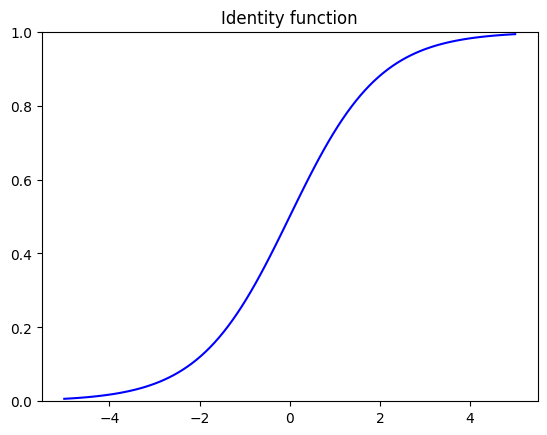

In [451]:
def ff(x):
    return x
def fff(x):
    return torch.sigmoid(ff(x))

plot_function(fff, "Identity function", min=-5, max=5, color='b', ylim=(0,1))

In [452]:
def calc_preds_sig(params, ts):
    return torch.sigmoid((ts * params).sum(axis=1))


In [453]:
params1 = train_model(init_params(), train_ts, result_ts, 0.2, 18, calc_preds_func=calc_preds)
params2 = train_model(init_params(), train_ts, result_ts, 100, 30, calc_preds_func=calc_preds_sig)
calc_loss(calc_preds(params1, train_ts), result_ts), calc_loss(calc_preds_sig(params2, train_ts), result_ts),accuracy(params1,calc_preds), accuracy(params2, calc_preds_sig) 

0.734; 0.663; 0.609; 0.560; 0.513; 0.467; 0.435; 0.433; 0.395; 0.394; 0.377; 0.374; 0.352; 0.350; 0.335; 0.329; 0.317; 0.311; 
loss: 0.311
0.519; 0.317; 0.257; 0.201; 0.197; 0.195; 0.194; 0.193; 0.193; 0.192; 0.192; 0.192; 0.191; 0.191; 0.191; 0.191; 0.191; 0.191; 0.191; 0.191; 0.191; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 0.190; 
loss: 0.190


(tensor(0.3105, grad_fn=<MeanBackward0>),
 tensor(0.1901, grad_fn=<MeanBackward0>),
 tensor(0.7856),
 tensor(0.8114))